### Data preparation

* Check if the missing values are presented in the features.
* If there are missing values:
    * For caterogiral features, replace them with 'NA'
    * For numerical features, replace with with 0.0 

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
url = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv'
df = pd.read_csv(url)

In [2]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [3]:
# Check for missing values
print(df.isnull().sum())

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64


In [4]:
# Replace missing values
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna('NA')
    else:
        df[col] = df[col].fillna(0.0)

In [5]:
print(df.isnull().sum())

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64


In [6]:
# Split the data
df_train, df_temp = train_test_split(df, test_size=0.4, random_state=1)
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [7]:
len(df_train), len(df_val), len(df_test)

(877, 292, 293)

In [8]:
type(df_train)

pandas.core.frame.DataFrame

### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the `converted` variable as ground truth.
* Use the training dataset for that

If your AUC is < 0.5, invert this variable by putting \"-\" in front

(e.g. `-df_train['balance']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `lead_score`
- **`number_of_courses_viewed`**
- `interaction_count`
- `annual_income`

In [9]:
from sklearn.metrics import roc_auc_score

numerical = df_train[['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']].copy()
target = df_train['converted'].copy()

for col in numerical.columns: # Iterate over column names data
    auc = roc_auc_score(target, numerical[col]) # Use numerical[col] for the data
    # If the auc is negative, invert the variable and recalculate
    if auc < 0.5:
        auc = roc_auc_score(target, -numerical[col])
    print(f'{col}: {auc}')

lead_score: 0.6111168681007025
number_of_courses_viewed: 0.7652439024390244
interaction_count: 0.7271914132379249
annual_income: 0.5446354552990968


### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.32
- 0.52
- 0.72
- **0.92**

In [10]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
import numpy as np

# One-hot encoding
dv = DictVectorizer(sparse=False)
train_dict = df_train.drop(columns='converted').to_dict(orient='records')
val_dict = df_val.drop(columns='converted').to_dict(orient='records')

X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)
y_train = df_train['converted'].values
y_val = df_val['converted'].values

# Train the model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print(f'AUC: {auc:.3f}')

AUC: 0.794


In [11]:
# The annual_income column and the lead_score column are on very different scales.
#Scaling numerical features can help the optimization algorithm converge faster and more reliably.

from sklearn.preprocessing import StandardScaler

# One-hot encoding
dv = DictVectorizer(sparse=False)
train_dict = df_train.drop(columns='converted').to_dict(orient='records')
val_dict = df_val.drop(columns='converted').to_dict(orient='records')

X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)
y_train = df_train['converted'].values
y_val = df_val['converted'].values

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Train the model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print(f'AUC: {auc:.3f}')

AUC: 0.905


### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.145
* 0.345
* **0.545**
* 0.745

In [12]:
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt

# Define thresholds from 0.0 to 1.0 with a step of 0.01
thresholds = np.arange(0.0, 1.01, 0.01)

# Store precision and recall for each threshold
precision = []
recall = []

# Compute precision and recall for each threshold
for t in thresholds:
    # If threshold is lower than prediction classify it as a positive case
    y_pred_class = (y_pred >= t)
    
    # Calculate precision and recall
    # Below can be calculated with precision_score and recall_score (see F1 score below):
    #    p = precision_score(y_val, y_pred_class.astype(int), zero_division=0)
    #    r = recall_score(y_val, y_pred_class.astype(int), zero_division=0)
    tp = ((y_pred_class == 1) & (y_val == 1)).sum()  # Predicted positive and actually positive
    fp = ((y_pred_class == 1) & (y_val == 0)).sum()  # Predicted positive but actually negative
    fn = ((y_pred_class == 0) & (y_val == 1)).sum()  # Predicted negative but actually positive
    
    # Handle division by zero
    p = tp / (tp + fp) if (tp + fp) > 0 else 0.0 
    r = tp / (tp + fn) if (tp + fn) > 0 else 0.0 
    
    # Append results
    precision.append(p)
    recall.append(r)

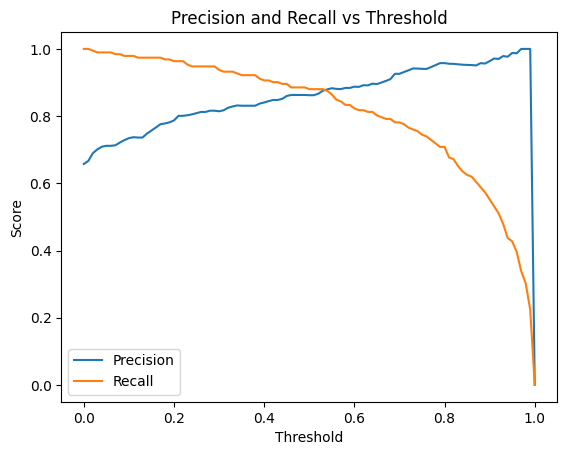

In [13]:
# Plot precision and recall curves
plt.plot(thresholds, precision, label='Precision')
plt.plot(thresholds, recall, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.title('Precision and Recall vs Threshold')
plt.show()

In [14]:
# Find the threshold where precision equals recall
precision = np.array(precision)  # Convert to NumPy arrays for vectorized operations
recall = np.array(recall)

# Calculate the absolute difference between precision and recall, excluding cases where both are zero
diff = np.where((precision == 0.0) & (recall == 0.0), np.inf, np.abs(precision - recall)) # np.where(condition, value_if_true, value_if_false)

# Find the index of the minimum difference
min_diff_index = np.argmin(diff)

# Get the corresponding threshold
threshold_equal = thresholds[min_diff_index]
print(f"Threshold where precision equals recall: {threshold_equal:.3f}")

Threshold where precision equals recall: 0.530


### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metric that takes into account both.

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.14
- 0.34
- **0.54**
- 0.74

In [15]:
# Compute F1 score for each threshold
F1_scores = []

for t in thresholds:
    y_pred_class = (y_pred >= t)
    p = precision_score(y_val, y_pred_class.astype(int), zero_division=0)
    r = recall_score(y_val, y_pred_class.astype(int), zero_division=0)
    f1 = 2 * (p * r) / (p + r) if (p + r) > 0 else 0
    F1_scores.append(f1)

# Find the threshold with the maximum F1 score
max_f1_index = np.argmax(F1_scores)
max_f1_threshold = thresholds[max_f1_index]
print(f'Max F1 Score: {F1_scores[max_f1_index]:.3f} at Threshold: {max_f1_threshold:.2f}')

Max F1 Score: 0.878 at Threshold: 0.53


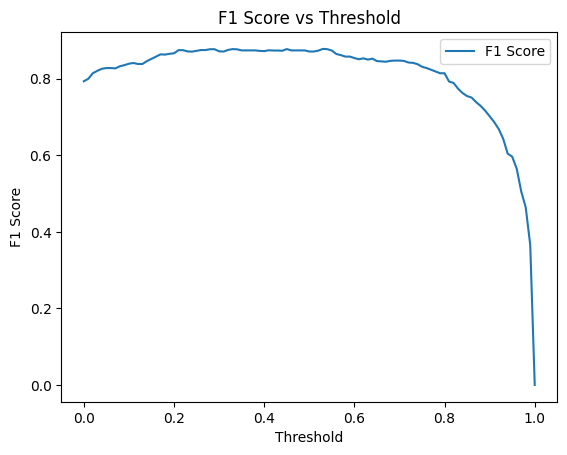

In [16]:
# Plot F1 score curve
plt.plot(thresholds, F1_scores, label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.legend()
plt.show()

### Question 5: 5-Fold CV

Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- **0.006**
- 0.06
- 0.36

In [18]:
from sklearn.model_selection import KFold

# Combine training and validation data
df_full_train = pd.concat([df_train, df_val]).reset_index(drop=True)
y_full_train = np.concatenate([y_train, y_val])

# Set up K-Fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

# Train and evaluate the model for each fold
for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    y_train = y_full_train[train_idx]
    y_val = y_full_train[val_idx]

    # One-hot encoding
    train_dict = df_train.drop(columns='converted').to_dict(orient='records')
    val_dict = df_val.drop(columns='converted').to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)
    X_val = dv.transform(val_dict)

    # Train the model
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict_proba(X_val)[:, 1] # Probability of class 1
    
    # Compute AUC score
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
    print(auc)

0.7735762400489896
0.8201367781155016
0.8424427242161231
0.8568672839506174
0.8324398960363874


In [19]:
# Print the mean and standard deviation of AUC scores
print(f'Mean AUC: {np.mean(scores):.3f}, Std AUC: {np.std(scores):.3f}')

Mean AUC: 0.825, Std AUC: 0.028


In [20]:
# With StandardScaler
# Combine training and validation data
df_full_train = pd.concat([df_train, df_val]).reset_index(drop=True)
y_full_train = np.concatenate([y_train, y_val])

# Set up K-Fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

# Train and evaluate the model for each fold
for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    y_train = y_full_train[train_idx]
    y_val = y_full_train[val_idx]

    # One-hot encoding
    dv = DictVectorizer(sparse=False)
    train_dict = df_train.drop(columns='converted').to_dict(orient='records')
    val_dict = df_val.drop(columns='converted').to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)
    X_val = dv.transform(val_dict)

    # Scale the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    # Train the model
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict_proba(X_val)[:, 1]  # Probability of class 1
    
    # Compute AUC score
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
    print(auc)

# Print the mean and standard deviation of AUC scores with StandardScaler
print(f'Mean AUC: {np.mean(scores):.3f}, Std AUC: {np.std(scores):.3f}')

0.9140477686989315
0.9332826747720364
0.8988975091874235
0.9125876707272056
0.9404411764705882
Mean AUC: 0.920, Std AUC: 0.015


### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.000001
- 0.001
- **1**

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

In [21]:
# Hyperparameter tuning
C_values = [0.000001, 0.001, 1]

for C in C_values:
    scores = []
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
        y_train = y_full_train[train_idx]
        y_val = y_full_train[val_idx]

        # One-hot encoding
        train_dict = df_train.drop(columns='converted').to_dict(orient='records')
        val_dict = df_val.drop(columns='converted').to_dict(orient='records')
        X_train = dv.fit_transform(train_dict)
        X_val = dv.transform(val_dict)

        # Train the model
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)

        # Evaluate the model
        y_pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
        print(auc)

0.5276555625392835
0.5534194528875379
0.5524703960800327
0.5325950535252861
0.561437908496732
0.8681646763042111
0.85790273556231
0.8552062066149448
0.858250276854928
0.8709967320261438
0.8128535512256443
0.8209726443768998
0.8107799101674152
0.835142118863049
0.8401960784313726


In [22]:
# Print mean and standard deviation of AUC scores for the current C value
print(f'C={C}, Mean AUC: {np.mean(scores):.3f}, Std AUC: {np.std(scores):.3f}')

C=1, Mean AUC: 0.824, Std AUC: 0.012


In [24]:
# With StandardScaler
C_values = [0.000001, 0.001, 1]

for C in C_values:
    scores = []
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
        y_train = y_full_train[train_idx]
        y_val = y_full_train[val_idx]

        # One-hot encoding
        dv = DictVectorizer(sparse=False)
        train_dict = df_train.drop(columns='converted').to_dict(orient='records')
        val_dict = df_val.drop(columns='converted').to_dict(orient='records')
        X_train = dv.fit_transform(train_dict)
        X_val = dv.transform(val_dict)

        # Scale the features
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)

        # Train the model
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)

        # Evaluate the model
        y_pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
        print(f'C={C}, AUC: {auc:.3f}')

# Print mean and standard deviation of AUC scores for the current C value with StandardScaler
print(f'C={C}, Mean AUC: {np.mean(scores):.3f}, Std AUC: {np.std(scores):.3f}')

C=1e-06, AUC: 0.900
C=1e-06, AUC: 0.918
C=1e-06, AUC: 0.882
C=1e-06, AUC: 0.895
C=1e-06, AUC: 0.936
C=0.001, AUC: 0.904
C=0.001, AUC: 0.923
C=0.001, AUC: 0.885
C=0.001, AUC: 0.901
C=0.001, AUC: 0.938
C=1, AUC: 0.914
C=1, AUC: 0.933
C=1, AUC: 0.899
C=1, AUC: 0.913
C=1, AUC: 0.940
C=1, Mean AUC: 0.920, Std AUC: 0.015
